In [1]:
%matplotlib inline

import fipy as fp
import fipy.tools.numerix as numerix

In [2]:
nx = 200
ny = 200
dx = 0.25
dy = 0.25
mesh = fp.Grid2D(nx=nx, ny=ny, dx=dx, dy=dy)

In [3]:
mm = 4
epsilon_m = 0.025
theta_0 = 0.0
tau_0 = 1.
DD = 10.
W_0 = 1.
lamda = DD * tau_0 / 0.6267 / W_0**2
delta = 0.05

In [4]:
phase = fp.CellVariable(mesh=mesh, hasOld=True)
uu = fp.CellVariable(mesh=mesh, hasOld=True)
dt = fp.Variable(0.01)
uu.constrain(-delta, mesh.exteriorFaces)

In [5]:
def initialize():
    phase[:] = -1.0
    x, y = mesh.cellCenters
    radius = 4.0
    center = (nx * dx / 2., ny * dy / 2.)
    mask = (x - center[0])**2 + (y - center[1])**2 < radius**2
    phase.setValue(1., where=mask)
    uu[:] = -delta
initialize()

In [6]:
def make_tau(phase_):
    theta_cell = numerix.arctan2(phase_.grad[1], phase_.grad[0])
    a_cell = 1 + epsilon_m * numerix.cos(mm * theta_cell - theta_0)
    return tau_0 * a_cell**2

tau = make_tau(phase)
tau_old = make_tau(phase.old)

In [7]:
#source_explicit = 2 * phase**3 - lamda * uu * (1 - phase**2) * (1 + 3 * phase**2)
#source_implicit = (1 - 3 * phase**2) + 4 * lamda * uu * phase * (1 - phase**2)
source = (phase - lamda * uu * (1 - phase**2)) * (1 - phase**2)
#source_explicit = phase * (1 - phase**2)
#source_implicit

In [8]:
theta = numerix.arctan2(phase.faceGrad[1], phase.faceGrad[0])
W = W_0 * (1 + epsilon_m * numerix.cos(mm * theta - theta_0))

W_theta = - W_0 * mm * epsilon_m * numerix.sin(mm * theta - theta_0)

I0 = fp.Variable(value=((1,0), (0,1)))
I1 = fp.Variable(value=((0,-1), (1,0)))

Dphase = W**2 * I0 + W * W_theta * I1

In [9]:
heat_eqn = fp.TransientTerm() == fp.DiffusionTerm(DD) + (phase - phase.old) / dt / 2.

phase_eqn = fp.TransientTerm(tau) == fp.DiffusionTerm(Dphase) + source

# + \
 #           fp.ImplicitSourceTerm(source_implicit) #- fp.ImplicitSourceTerm(tau_old / dt) + tau * phase / dt

In [10]:
print max(tau), min(tau)

1.050625 0.950625


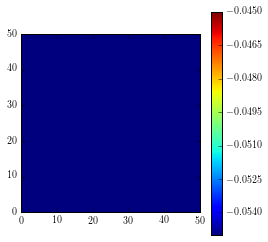

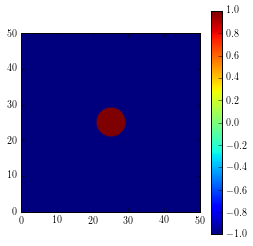

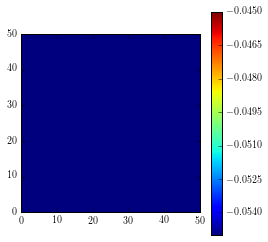

In [11]:
phase_viewer = fp.Viewer(phase)
uu_viewer = fp.Viewer(uu)
phase_viewer.plot()
uu_viewer.plot()

In [12]:
initialize()
#dt.setValue(0.01)
total_steps = 40
sweeps = 5
tolerance = 1e-1
from fipy.solvers.pysparse import LinearLUSolver as Solver
solver_heat = Solver()
solver_phase = Solver()

current_step = 0
while current_step < total_steps:
    uu.updateOld()
    phase.updateOld()

    res_heat0 = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
    res_phase0 = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    for sweep in range(sweeps):
        res_heat = heat_eqn.sweep(uu, dt=dt.value, solver=solver_heat)
        res_phase = phase_eqn.sweep(phase, dt=dt.value, solver=solver_phase)

    
    print
    print 'dt',dt  
    print 'current_step',current_step
    print 'res_heat',res_heat0, res_heat
    print 'res_phase',res_phase0, res_phase
    if (res_heat < res_heat0 * tolerance) and (res_phase < res_phase0 * tolerance):
        current_step += 1
        dt.setValue(dt.value * 1.1)
    else:
        dt.setValue(dt.value * 0.8)
        uu[:] == uu.old
        phase[:] = phase.old




dt 0.01
current_step 0
res_heat 0.0 3.09022299806e-05
res_phase 41.8008056236 1.0111710577e-05

dt 0.008
current_step 0
res_heat 10.2428446264 2.17102830237e-05
res_phase 41.8008056236 5.79852916574e-06

dt 0.0088
current_step 1
res_heat 12.5595580394 4.07909492024e-05
res_phase 26.075520577 9.32907318522e-06

dt 0.00968
current_step 2
res_heat 8.83341040347 6.94061906573e-05
res_phase 16.7833750481 2.36573593583e-05

dt 0.010648
current_step 3
res_heat 6.03221638441 4.63965850817e-05
res_phase 11.3812463283 1.91357051117e-05

dt 0.0117128
current_step 4
res_heat 4.32567284114 2.36386515262e-05
res_phase 8.2122248479 1.07535145203e-05

dt 0.01288408
current_step 5
res_heat 3.28224498323 1.26322862759e-05
res_phase 6.26572285462 5.65338425253e-06

dt 0.014172488
current_step 6
res_heat 2.60785552511 9.41908361202e-06
res_phase 4.99493883572 3.68449814681e-06

dt 0.0155897368
current_step 7
res_heat 2.14261490677 9.15681613997e-06
res_phase 4.11183794904 3.0030610786e-06

dt 0.017148710

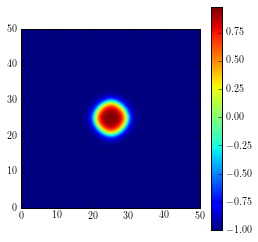

In [13]:
phase_viewer.plot()

In [54]:
max(phase)

0.99373069742389353

In [ ]:
from fipy.tools impor